# Part1: Decision Tree

In [17]:
import numpy as np
import pandas as pd
import sys
import random
from collections import Counter
import matplotlib.pyplot as plt

In [18]:
def train_test_split(data, train_percent,test_percent,random_seed):
    if random_seed is not None:
        random.seed(random_seed)

    data_size = len(data)
    total_percent = train_percent + test_percent                #100%
    train_size = int(train_percent / total_percent * data_size)
    test_size = int(test_percent / total_percent * data_size)

    # Shuffle the data randomly
    data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Splitting the data into training and test sets
    train_data = data.iloc[:train_size, :]
    test_data = data.iloc[train_size:data_size-1, :]

    return train_data, test_data

In [19]:
data=pd.read_csv('/content/Q1Data.csv')
train_data,test_data = train_test_split(data,train_percent=20,test_percent=80,random_seed=42)
train_data=train_data.iloc[:,:].values
test_data=test_data.iloc[:,:].values
print(len(train_data))

1439


# Node Class

In [20]:
class Node():
      def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        #constructor

        self.feature_index=feature_index
        self.threshold=threshold
        self.left=left
        self.right=right
        self.info_gain=info_gain

        #leaf node
        self.value=value

# Decision tree Class

In [21]:
class DecisionTreeClassifier():
  def __init__(self,max_depth=15):
    #constructor

    self.root=None
    self.max_depth=max_depth

  def build_tree(self,data,curr_depth=0):
    # print("build_tree")
    X = data[:,:6] #features(mfcc1->mfcc6)
    y = data[:,-2] #target(genus)
    num_samples, num_features = np.shape(X)
    #base case
    if(num_samples>=2 and curr_depth<=self.max_depth):
      #find the best split
      best_split=self.find_best_split(data,num_samples,num_features)
      # gets a dictionary
      if (best_split["info_gain"]>0):
        #left subtree
        left_subtree = self.build_tree(best_split["data_left"],curr_depth+1)
        #right subtree
        right_subtree = self.build_tree(best_split["data_right"],curr_depth+1)
        #after building both left and right subtrees it backtracks
        return Node(best_split["feature_index"],best_split["threshold"],left_subtree,right_subtree,best_split["info_gain"])
    # compute leaf node
    leaf_value = self.calculate_leaf_value(y)
    # return leaf node
    return Node(value=leaf_value)

  def find_best_split(self,data,num_samples,num_features):
    best_split={}
    max_info_gain = -float("inf")
    #iterate through all features
    for feature_index in range(num_features):
      #get the current feature values
      feature_values = data[:,feature_index]
      #get the possible thresholds (ranges)
      possible_thresholds = np.unique(feature_values)
      #iterate through each threshold
      for threshold in possible_thresholds:
        #dividing dataset into two splits (<=threshold and >threshold) based on the current feature values
        left_split, right_split = self.split(data,feature_index,threshold)

        if(len(left_split)>0 and len(right_split)>0):
          target = data[:,-2]
          left_target = left_split[:,-2]
          right_target = right_split[:,-2]
          curr_info_gain = self.info_gain(target,left_target,right_target)
          if curr_info_gain > max_info_gain:
            best_split["feature_index"] = feature_index
            best_split["threshold"] = threshold
            best_split["data_left"] = left_split
            best_split["data_right"] = right_split
            best_split["info_gain"] = curr_info_gain
            max_info_gain = curr_info_gain
    return best_split
  def split(self,data,feature_index,threshold):
    data = np.array(data)

    # boolean indexing for left and right splits
    left_split = data[data[:, feature_index] <= threshold]
    right_split = data[data[:, feature_index] > threshold]

    return left_split, right_split

  def info_gain(self,target,left_target,right_target):
    # print(left_target)
    # print(right_target)
    w_l = len(left_target)/len(target)
    w_r = len(right_target)/len(target)
    gain = self.gini_index(target) - (w_l*self.gini_index(left_target) + w_r*self.gini_index(right_target))

    return gain

  def gini_index(self,y):
    class_labels = np.unique(y)
    gini=0
    for cls in class_labels:
      p_cls=len(y[y==cls])/len(y)
      gini=gini+p_cls**2
    return 1-gini

  def fit(self,data):
    # print("fitting")
    self.root = self.build_tree(data)

  def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)

  def predict(self,X):
    predictions = [self.make_prediction(x, self.root) for x in X]
    return predictions

  def make_prediction(self,x,root):
    if(root.value!=None):
      return root.value
    feature_val=x[root.feature_index]
    if(feature_val<=root.threshold):
      return self.make_prediction(x,root.left)
    else:
      return self.make_prediction(x,root.right)

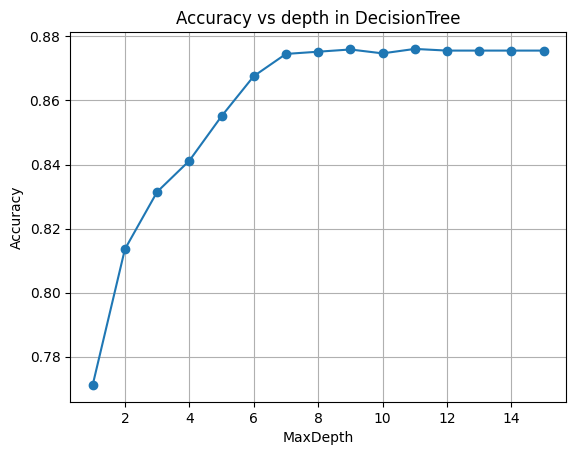

In [22]:
Accuracies=[]
for i in range(1 ,16):
  classifier = DecisionTreeClassifier(max_depth=i)
  classifier.fit(train_data)
  X_test = test_data[:,:6]
  y_test = test_data[:,-2]
  y_pred = classifier.predict(X_test)
  correct_predictions=0
  for i in range(len(y_test)):
    if(y_test[i]==y_pred[i]):
      correct_predictions+=1
  accuracy = correct_predictions/len(y_test)
  Accuracies.append(accuracy)
depth = range(1,16)
plt.plot(depth, Accuracies, marker='o')
plt.title('Accuracy vs depth in DecisionTree')
plt.xlabel('MaxDepth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

## Observations
* The accuracy of the decision tree here shows an upward trend with increasing depth, indicating an initial reduction in bias and improved capturing of patterns.
* The accuracy reaches its peak around a depth of 8, suggesting an optimal balance between model complexity and overfitting. Beyond this depth, the accuracy stabilizes, indicating that further increases in depth do not significantly contribute to improved generalization performance.

# Part2: K Nearest Neighbors

In [ ]:
import numpy as np
import pandas as pd
import sys
import random
from collections import Counter
import matplotlib.pyplot as plt

In [11]:
def train_test_split(data, train_percent,test_percent,random_seed):
    if random_seed is not None:
        random.seed(random_seed)

    data_size = len(data)
    total_percent = train_percent + test_percent                #100%
    train_size = int(train_percent / total_percent * data_size)
    test_size = int(test_percent / total_percent * data_size)

    # Shuffle the data randomly
    data = data.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Splitting the data into training and test sets
    train_data = data.iloc[:train_size, :]
    test_data = data.iloc[train_size:data_size-1, :]

    return train_data, test_data


percentage_to_load = 0.4

data = pd.read_csv('/content/Q1Data.csv')

#randomly taking only 40 percent of data
data=data.sample(frac=percentage_to_load, random_state=42)

# print(len(data))

train_data, test_data = train_test_split(data, train_percent=0.75, test_percent=0.25, random_seed=42)

print(len(train_data))
print(len(test_data))

2158
719


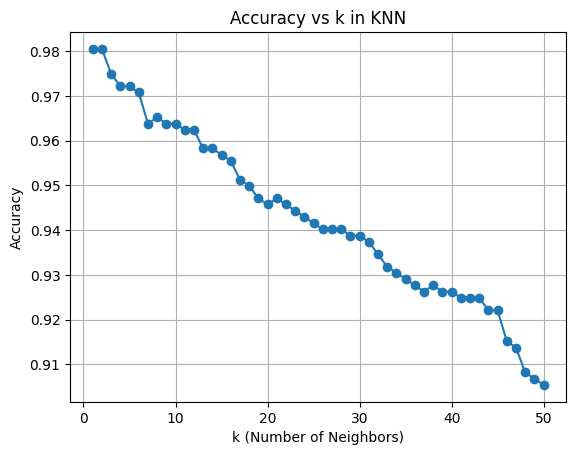

In [13]:
test_size = len(test_data)
Accuracies_knn = []

for k in range(1, 51):
    correct_predictions = 0

    for i in range(test_size):
        x = test_data.iloc[i, :21].values
        # Getting all the distances
        distances = np.linalg.norm(train_data.iloc[:, :21].values.astype(np.float64) - x.astype(np.float64), axis=1)

        #getting the k nearest ids
        knn_ids = distances.argsort()[:k]  # k=1-50

        # Use Counter to count occurrences directly
        knn_genus = Counter(train_data.iloc[knn_ids, train_data.columns.get_loc('Genus')])

        # Majority vote
        predicted = knn_genus.most_common(1)[0][0]
        actual = test_data.iloc[i, train_data.columns.get_loc('Genus')]

        if predicted == actual:
            correct_predictions += 1

    accuracy = correct_predictions / test_size
    Accuracies_knn.append(accuracy)

# print(Accuracies)
k_values = range(1, 51)
plt.plot(k_values, Accuracies_knn, marker='o')
plt.title('Accuracy vs k in KNN')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


# Observations
* As we increase the k value the accuracy becoming lower, this indicates that model becoming more flexible and it starts considering more neighbors for making predictions, and this can make it less able to adapt to specific patterns in the data.

# Part3: Using Scikit - Learn functions

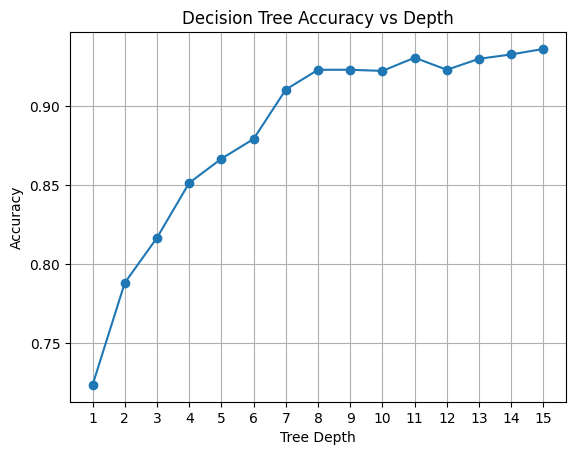

In [10]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

df = pd.read_csv("/content/Q1Data.csv", skiprows=1)
X = df.iloc[:, 0:21]
Y = df.iloc[:, 22]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=47)

depths = list(range(1, 16))
accuracies = []

for depth in depths:
    # Create a Decision Tree model with the specified depth
    tree_model = DecisionTreeClassifier(max_depth=depth, random_state=47)

    tree_model.fit(X_train, Y_train)

    Y_pred = tree_model.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)

# Plotting
plt.plot(depths, accuracies, marker='o')
plt.title('Decision Tree Accuracy vs Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.xticks(np.arange(1, 16, step=1))
plt.grid(True)
plt.show()

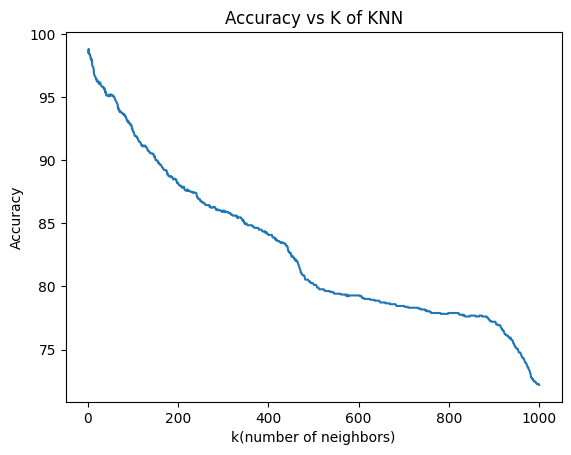

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


df = pd.read_csv("/content/Q1Data.csv", skiprows=1)
X = df.iloc[:, 0:21]
Y = df.iloc[:, 22]


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, train_size=0.8, random_state=47)

accuracies_knn = []
kvalues = list(range(1, 1001))

for i in kvalues:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, Y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred) * 100
    accuracies_knn.append(accuracy)
plt.plot(kvalues, accuracies_knn)
plt.xlabel('k(number of neighbors)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs K of KNN')
plt.show()

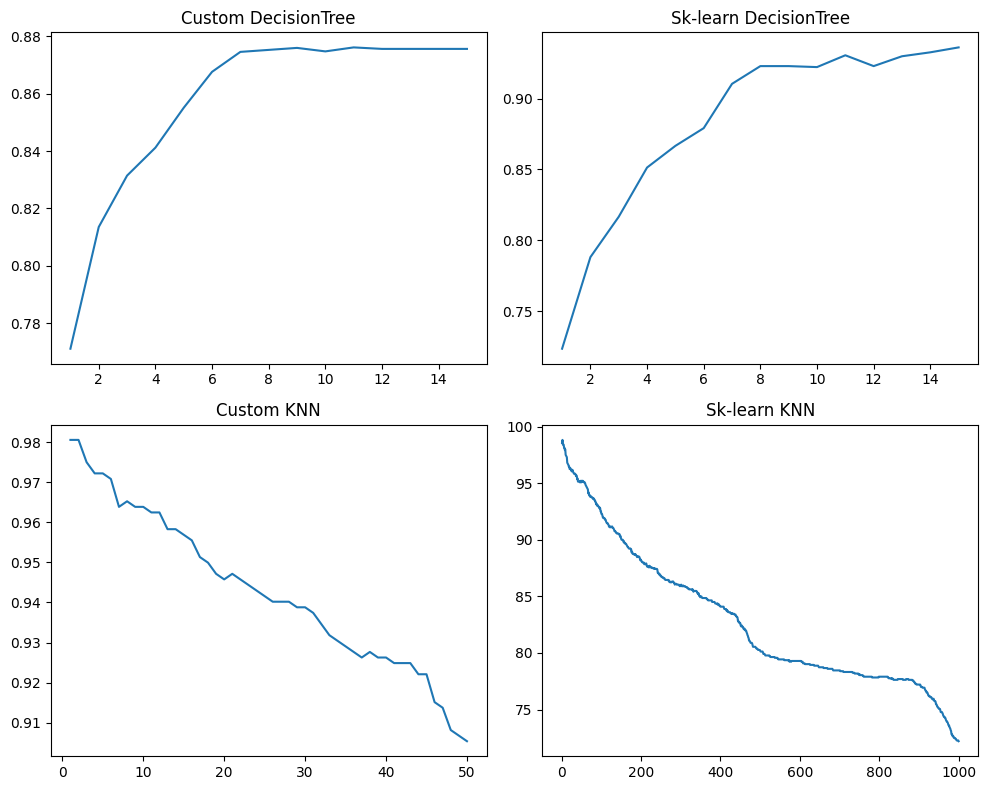

In [23]:
# Comparing all plots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

axes[0, 0].plot(depths,Accuracies)
axes[0, 0].set_title('Custom DecisionTree')

axes[0, 1].plot(depths,accuracies)
axes[0, 1].set_title('Sk-learn DecisionTree')

axes[1, 0].plot(k_values, Accuracies_knn)
axes[1, 0].set_title('Custom KNN')

k_values=range(1,1001)
axes[1, 1].plot(k_values, accuracies_knn)
axes[1, 1].set_title('Sk-learn KNN')

plt.tight_layout()

plt.show()

# Observations
## Sklearn vs Custom Decision tree
* When we compare Sklearn's decision tree and custom decision tree graphs, It is clear that the Sklearn's decision tree performed pretty good at higher depth values  due to it is more exposed to all the features, so it can identify more intricate patterns than the custom decision tree which is only using features [1 to 6].
## Sklearn vs Custom KNN
* As we can see the Sklearn's KNN gave better accuracies than the custom KNN at initial 50 k - values as it is trained with more training data than the custom KNN.